In [1]:
import nilearn.image as ni
import nibabel as nb
from nilearn.plotting import plot_anat
import SimpleITK as sitk

#%matplotlib notebook
#import gui


In [2]:
sub_bse_t2 = '/deneb_disk/macaque_atlas_data/test_data/MAC10.nii.gz'
sub_mask_t2 = '/deneb_disk/macaque_atlas_data/test_data/MAC10.mask.nii.gz'
atlas_bse_t2 = '/deneb_disk/macaque_atlas_data/macaque_atlas/ONPRC18_atlas_v1/ONPRC18_Templates/ONPRC18_T2W_brain.nii.gz'


"""
reader = sitk.ImageSeriesReader()
fixed_image = sitk.ReadImage(sub_bse_t2, sitk.sitkFloat32)
moving_image = sitk.ReadImage(atlas_bse_t2, sitk.sitkFloat32)



gui.MultiImageDisplay(image_list = [fixed_image, moving_image],                   
                      title_list = ['fixed image', 'moving image']);
"""

"\nreader = sitk.ImageSeriesReader()\nfixed_image = sitk.ReadImage(sub_bse_t2, sitk.sitkFloat32)\nmoving_image = sitk.ReadImage(atlas_bse_t2, sitk.sitkFloat32)\n\n\n\ngui.MultiImageDisplay(image_list = [fixed_image, moving_image],                   \n                      title_list = ['fixed image', 'moving image']);\n"

(256, 80, 256)


/home/ajoshi/anaconda3/lib/python3.10/site-packages/nilearn/plotting/find_cuts.py:143: UserWarning: Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.
  warnings.warn(


(137, 80, 166)


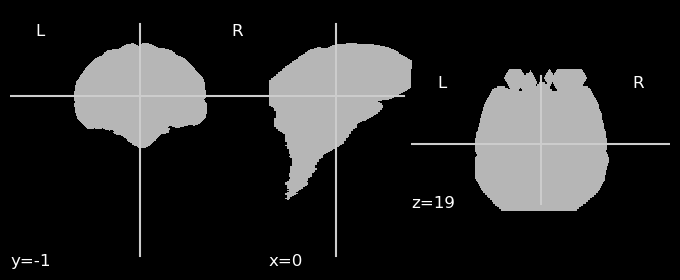

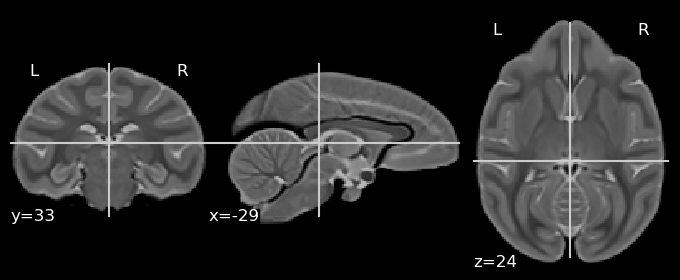

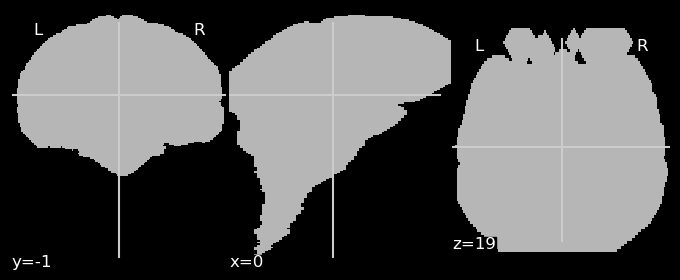

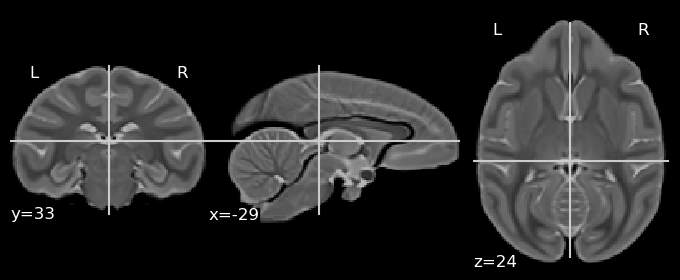

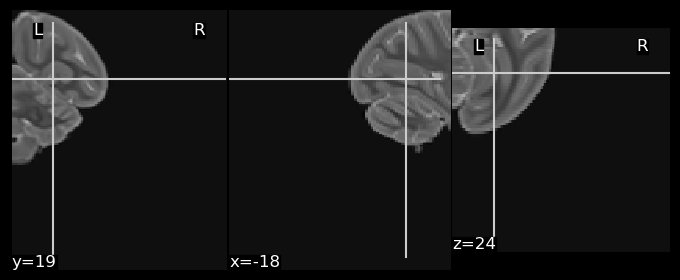

In [3]:
sub_msk = ni.load_img(sub_mask_t2)
print(sub_msk.shape)
plot_anat(sub_msk)
plot_anat(atlas_bse_t2)

sub_msk=ni.crop_img(sub_msk)
atlas=ni.crop_img(atlas_bse_t2)

print(sub_msk.shape)
plot_anat(sub_msk)
plot_anat(atlas)
atlas = ni.resample_to_img(atlas,sub_msk)
plot_anat(atlas)
